# Logistic Reression with a Neural Network mindset

We will build  a logistic regression classifier to recognize cats through neural network mindset.

**In this notebook**
- Build the general architecture of a learning algorithm, including:
1. Initializing parameters
2. Calculating the cost function and its gradient
3. Using an optimization algorithm (gradient descent)
- Gather all three functions above into a main model function, in the right order

## 1. Importing importing packages

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset


%matplotlib inline


In [3]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## 2. Overview of the problem set

`Problem Statement`: You are given a dataset ("data.h5") containing:

- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code

In [4]:
# Loading the data
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the index value and re-run to see other images.

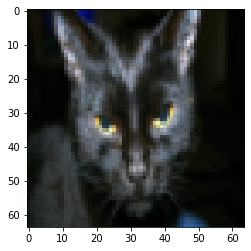

In [9]:
import matplotlib.pyplot as plt
#example of a picture
index = 25
plt.imshow(train_set_x_orig[index])


Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

`Exercise`: Find the values for:

- m_train (number of training examples)
- m_test (number of test examples)
- num_px (= height = width of a training image)

Remember that train_set_x_orig is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access m_train by writing train_set_x_orig.shape[0].

In [10]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = test_set_x_orig.shape[1]

print('Number of training examples: m_train = ', str(m_train))
print('Number of testing examples: m_test = ', str(m_test))
print('Heigh and width of each image: num_px = ', str(num_px))
print('Each image is of size:(' + str(num_px) + ', ' + str(num_px) + ', 3)')
print('train_set_x shape: ' + str(train_set_x_orig.shape))
print('train_set_y shape: ' + str(train_set_y.shape))
print('test_set_x shape: ' + str(test_set_x_orig.shape))
print('test_set_y shape: ' + str(test_set_y.shape))


Number of training examples: m_train =  209
Number of testing examples: m_test =  50
Heigh and width of each image: num_px =  64
Each image is of size:(64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px  ∗  num_px  ∗  3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise**: Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px  ∗  num_px  ∗  3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b ∗ c ∗ d, a) is to use:

X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X

In [12]:
# Reshape the training and test examples


train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten =  test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.

In [13]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

**What you need to remember:**

Common steps for pre-processing a new dataset are:

- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1)
- "Standardize" the data

## 3 - General Architecture of the learning algorithm
It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset.

## 4 - Building the parts of our algorithm
The main steps for building a Neural Network are:

1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
-  Calculate current loss (forward propagation)
-  Calculate current gradient (backward propagation)
-  Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call model().

## 4.1 - Helper Functions
We need to compute sigmoid to make predictions. Use np.exp().

In [16]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [17]:
print('sigmoid[0, 2]: ' +str(sigmoid(np.array([0,2]))))

sigmoid[0, 2]: [0.5        0.88079708]


## 4.2 Initializing parameters
We have to initialize w as a vector of zeros. We will use np.zeros() function.

In [20]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b, int))
    
    return w, b

In [21]:
dim = 2
w, b = initialize_with_zeros(dim)
print("w = " +str(w))
print("b = " +str(b))

w = [[0.]
 [0.]]
b = 0


For image inputs, w will be of shape (num_px  ×  num_px  ×  3, 1).

## 4.3 - Forward and Backward propagation
Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise**: Implement a function propagate() that computes the cost function and its gradient

In [29]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
        
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)                                     # compute activation
    cost = -1./m* np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))                                  # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1./m*np.dot(X, (A-Y).T)
    db = 1./m*np.sum(A-Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    #cost = np.squeeze(cost)
    #assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [31]:
#w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2], [3,4]]), np.array([[1,0]])
grads, cost = propagate(w,b,X,Y)
print("dw =" +str(grads["dw"]))
print("db =" +str(grads["db"]))
print("cost =" +str(cost))

dw =[[0.99993216]
 [1.99980262]]
db =0.49993523062470574
cost =6.000064773192205


## d) Optimization

- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

`Exercise`: Write down the optimization function. The goal is to learn  w  and  b  by minimizing the cost function  J . For a parameter  θ , the update rule is  θ=θ−α dθ , where  α  is the learning rate.

In [32]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    costs = []
    for i in range(num_iterations):
        
        #cost and gradient calculations
        grads, cost = propagate(w,b,X,Y)
        
        
        #retrieve derivative from grads
        dw = grads["dw"]
        db = grads["db"]
        
        #update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [33]:
params, grads, costs = optimize(w,b,X,Y, num_iterations=100, learning_rate=0.009, print_cost=False)
print("w = " +str(params["w"]))
print("b = " +str(params["b"]))
print("dw = " +str(grads["dw"]))
print("db = " +str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


**Exercise**: The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function. There is two steps to computing predictions:

- Calculate  Y^=A=σ(wTX+b) 
- Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [34]:
def predict(w,b,X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A =   sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
             Y_prediction[0, i] = 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [35]:
print("predictions = " +str(predict(w,b,X)))

predictions = [[1. 1.]]


**What to remember**: You've implemented several functions that:

- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
  - computing the cost and its gradient
  - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model
You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise**: Implement the model function. Use the following notation:

- Y_prediction for your predictions on the test set
- Y_prediction_train for your predictions on the train set
- w, costs, grads for the outputs of optimize()

In [38]:
def model(X_train,Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    #initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])
    
    #gradient descent
    parameters, grads, costs = optimize(w,b, X_train, Y_train, num_iterations, learning_rate, print_cost = print_cost)
    
    #retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    #predict the train/test set samples
    Y_prediction_test = predict(w, b , X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    #print train/test accuracy
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train))*100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test))*100))
    
    d = {"costs":costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train": Y_prediction_train,
         "w": w,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations
        }
    return d

Run the following cell to train your model.

In [39]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


Training accuracy is close to **100%**. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test error is **70%**. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the index variable) you can look at predictions on pictures of the test set.

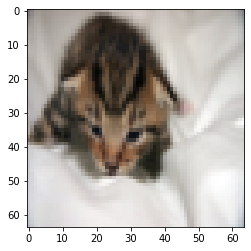

In [40]:
#exmple of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))

Let's also plot the cost function and gradients.

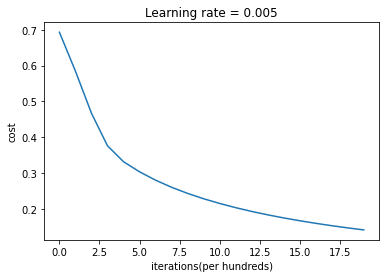

In [41]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations(per hundreds)')
plt.title("Learning rate = " + str(d["learning_rate"]))
plt.show()

**Interpretation**: You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting.